# EDA Notebook
- In this notebook we analyse the data set and perform a simple ETL workflow to move the relevant data into S3

## Import Packages

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import tarfile
import pickle

import sagemaker
from sagemaker import get_execution_role

## Load CIFAR-100 Dataset

In [3]:
def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    r = requests.get(url, stream=True) # stream=true prevents all data being loaded into memory at once
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return filename

In [5]:
Cifar_path = "../Data/cifar.tar.gz"
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz", Cifar_path)

'../Data/cifar.tar.gz'

# Extract data

In [7]:
# Defining Paths
extract_path = "../Data" # full path where data will be extracted

# defining paths where meta, test, train data will be extracted
meta_path = os.path.join(extract_path, "cifar-100-python", "meta")
test_path = os.path.join(extract_path, "cifar-100-python", "test")
train_path = os.path.join(extract_path, "cifar-100-python", "train")

In [8]:
# Extract to ../Data/
with tarfile.open(Cifar_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

# Load the files
with open(meta_path, "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open(test_path, "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open(train_path, "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

## Explore data

In [9]:
dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

## Examine data point
- As documented, `b'data'` contains rows of 3072 unsigned integers. Each row represents a single 32x32 color image, flattened into one vector: the first 1024 values are the red channel, the next 1024 are green, and the final 1024 are blue. Together, these form a full RGB image.

In [28]:
# start by looking at image in first row
data_index = 19
row = dataset_train[b'data'][data_index]

# Each 1024 in a row is a channel (red, green, then blue)
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

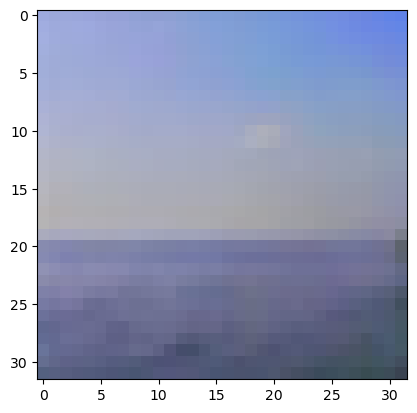

In [29]:
plt.imshow(test_image);

- We can extract the image label from `datasetdataset_train` and the label name from `dataset_meta`.

In [30]:
dataset_train[b'fine_labels'][data_index] # label of test image

71

In [31]:
print(dataset_meta[b'fine_label_names'][71])

b'sea'


In [32]:
# combined method
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][data_index]])

b'sea'


# Transform Data
## We need only vehicle data
- We will filter the dataset to contain only vehicle images.

In [35]:
# Examine labels and identify vehicle labels
print(dataset_meta[b'fine_label_names'])

[b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver', b'bed', b'bee', b'beetle', b'bicycle', b'bottle', b'bowl', b'boy', b'bridge', b'bus', b'butterfly', b'camel', b'can', b'castle', b'caterpillar', b'cattle', b'chair', b'chimpanzee', b'clock', b'cloud', b'cockroach', b'couch', b'crab', b'crocodile', b'cup', b'dinosaur', b'dolphin', b'elephant', b'flatfish', b'forest', b'fox', b'girl', b'hamster', b'house', b'kangaroo', b'keyboard', b'lamp', b'lawn_mower', b'leopard', b'lion', b'lizard', b'lobster', b'man', b'maple_tree', b'motorcycle', b'mountain', b'mouse', b'mushroom', b'oak_tree', b'orange', b'orchid', b'otter', b'palm_tree', b'pear', b'pickup_truck', b'pine_tree', b'plain', b'plate', b'poppy', b'porcupine', b'possum', b'rabbit', b'raccoon', b'ray', b'road', b'rocket', b'rose', b'sea', b'seal', b'shark', b'shrew', b'skunk', b'skyscraper', b'snail', b'snake', b'spider', b'squirrel', b'streetcar', b'sunflower', b'sweet_pepper', b'table', b'tank', b'telephone', b'television', b'ti

In [36]:
# Define the list of vehicle which may be suspeicious around ATM
vehicle_label_names = [
    b'bicycle',
    b'bus',
    b'motorcycle',
    b'pickup_truck',
    b'tractor',
    b'tank'
]

# Access the full list of label names from the CIFAR-100 meta
all_label_names = dataset_meta[b'fine_label_names']

# Map each vehicle label to its index in the full label list
vehicle_label_indices = [all_label_names.index(label) for label in vehicle_label_names]

# Print for verification
print("Vehicle label indices:", vehicle_label_indices)

Vehicle label indices: [8, 13, 48, 58, 89, 85]


In [38]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train[df_train['labels'].isin(vehicle_label_indices)] # keeps rows where label is 8 or 48
# Decode df_train.filenames so they are regular strings
# applying function to every value in filename column
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[df_test['labels'].isin(vehicle_label_indices)]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

In [45]:
# create directories for out filtered data
!mkdir ../Data/train_filtered
!mkdir ../Data/test_filtered

mkdir: cannot create directory ‘../Data/train_filtered’: File exists


In [46]:
def save_images(dataset_data, df, path):
    #Grab the image data in row-major form

    # make sure path exists
    os.makedirs(path, exist_ok=True)
    # create loop to loop through and get row data using .iterrows()
    for _, row in df.iterrows(): # '_' because we dont need actual row index
        img_data = dataset_data[row["row"]] # image data in row format

        # reshape into 3 rgb channels (32,32,3) array
        target = np.dstack((
            img_data[0:1024].reshape(32, 32),        # Red
            img_data[1024:2048].reshape(32, 32),     # Green
            img_data[2048:].reshape(32, 32)          # Blue
        ))

        # Save the image
        plt.imsave(path+row['filenames'], target)
    return f"Saved {len(df)} images to {path}"

In [47]:
save_images(dataset_train[b'data'], df_train, path="../Data/train_filtered/")
save_images(dataset_test[b'data'], df_test, path="../Data/test_filtered/")

'Saved 600 images to ../Data/test_filtered/'

# Load Data
## We will load into S3

In [54]:
bucket= 'sagemaker-us-east-1-351669278598'
print("Default Bucket: {}".format(bucket))

region = 'us-east-1'
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-351669278598
AWS Region: us-east-1
RoleArn: arn:aws:iam::351669278598:role/service-role/AmazonSageMaker-ExecutionRole-20250320T170250


In [55]:
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ../Data/train_filtered s3://${DEFAULT_S3_BUCKET}/vehicle_data/train/
!aws s3 sync ../Data/test_filtered s3://${DEFAULT_S3_BUCKET}/vehicle_data/test/

upload: ../Data/train_filtered/.ipynb_checkpoints/armored_combat_vehicle_s_000049-checkpoint.png to s3://sagemaker-us-east-1-351669278598/vehicle_data/train/.ipynb_checkpoints/armored_combat_vehicle_s_000049-checkpoint.png
upload: ../Data/train_filtered/armored_combat_vehicle_s_000024.png to s3://sagemaker-us-east-1-351669278598/vehicle_data/train/armored_combat_vehicle_s_000024.png
upload: ../Data/train_filtered/armored_combat_vehicle_s_000033.png to s3://sagemaker-us-east-1-351669278598/vehicle_data/train/armored_combat_vehicle_s_000033.png
upload: ../Data/train_filtered/armored_combat_vehicle_s_000017.png to s3://sagemaker-us-east-1-351669278598/vehicle_data/train/armored_combat_vehicle_s_000017.png
upload: ../Data/train_filtered/armored_combat_vehicle_s_000026.png to s3://sagemaker-us-east-1-351669278598/vehicle_data/train/armored_combat_vehicle_s_000026.png
upload: ../Data/train_filtered/armored_combat_vehicle_s_000031.png to s3://sagemaker-us-east-1-351669278598/vehicle_data/trai